### 1

![image](hw6_1a.jpg)

![image](hw6_1b.jpg)

#### 1c

If the training data isn't balanced, this will lead to $k$ being smaller. Smaller $k$ means that the classifier will have higher variance which means that the model will be less generalizable to new data.

#### 1d

I'd modify the data to randomly remove data points and are in the majority class so the training data is balanced. This could be done Monte Carlo style, and repeated many times

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve
from sklearn import metrics
from sklearn.model_selection import KFold


In [2]:
crossval = np.genfromtxt('dataSetCrossValWithKeys.csv',delimiter=',')
horseshoes = np.genfromtxt('dataSetHorseshoes.csv',delimiter=',')
horseshoesTEST = np.genfromtxt('dataSetHorseshoesTest.csv',delimiter=',')


### 2a

![image](hw6_2a.jpg)

#### 2b

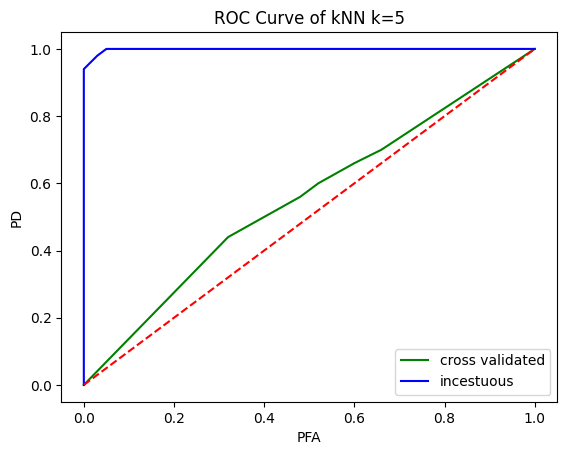

In [26]:
def myKNN(test_x, test_y,train_x, train_y, k=5):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(train_x,train_y)

    decision_stats = model.predict_proba(test_x)[:, 1]
    pFA, pD, threshold = roc_curve(test_y, decision_stats)
    maxPCD = 0
    for x in threshold:
        y_hat = np.where(decision_stats>=x, 1, 0)
        pCD = sum(y_hat==test_y) / test_y.shape[0]
        maxPCD = max(pCD,maxPCD)
    return pFA, pD, maxPCD

trainset = crossval[crossval[:,0]==1, :]
trainx = trainset[:,2:4]
trainy = trainset[:,1]

testset = crossval[crossval[:,0]==2, :]
testx = testset[:,2:4]
testy = testset[:,1]

cv_pfa, cv_pd, _ = myKNN(testx,testy,trainx,trainy)
crossvalx = crossval[:,2:4]
crossvaly = crossval[:,1]

incest_pfa, incest_pd, _ = myKNN(crossvalx,crossvaly,crossvalx,crossvaly)

fig, ax = plt.subplots()
ax.plot(cv_pfa, cv_pd, 'g', label="cross validated")
ax.plot(incest_pfa, incest_pd, 'b', label="incestuous")

ax.plot([0, 1], [0, 1],'r--')
ax.set_ylabel('PD')
ax.set_xlabel('PFA')
ax.set_title('ROC Curve of kNN k=5')
ax.legend()
plt.show()


The CV ROC is vastly different compared to the incestuous ROC. Contrary to my expectations in 2a, the CV ROC nearly follows the chance diagonal. On the other hand, the incestuous ROC was much more similar to my expectations.

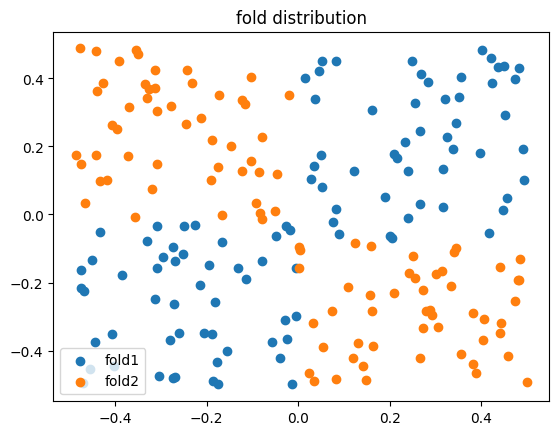

In [ ]:
fig, ax = plt.subplots()
fold0 = crossval[crossval[:,0]==1, :]
fold1 = crossval[crossval[:,0]==2, :]
# print(fold0.shape, fold1.shape)
x = crossval[:,2]
y = crossval[:,3]
 
ax.scatter(fold0[:,2],fold0[:,3],label="fold1")
ax.scatter(fold1[:,2],fold1[:,3],label="fold2")
ax.legend()
ax.set_title("fold distribution")

plt.show()

The ROC is different because the folds were poorly made. Fold 1, which was used for training, was made with only data points in the bottom left and top right quadrants. Thus, during testing, data points that are class 1 (on the right side) could have more nearest neighbors in the bottom right quadrant, thus causing misclassification. The same applies for data points that are class 0 (left side) having more nearest neighbors in the top right. 

#### 2c

To improve the estimates of classifier performance, the folds could've been made better. A better way of creating the folds would've been to randomly sample class 0 and class 1 data points instead of only selecting class 1 points in the top right and class 0 points in the bottom left.


#### 2d

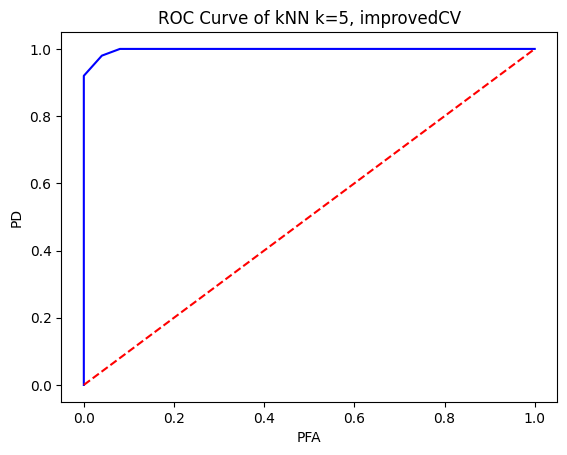

In [ ]:
class0 = crossval[crossval[:,1]==0, :]
class1 = crossval[crossval[:,1]==1, :]
from sklearn.model_selection import train_test_split
c0_train, c0_test, c1_train, c1_test = train_test_split(class0, class1, test_size=0.5)

fold1 = np.concatenate([c0_train,c1_train])
fold2 = np.concatenate([c0_test,c1_test])
myKNN(fold2[:,2:4],fold2[:,1],fold1[:,2:4],fold1[:,1], title='ROC Curve of kNN k=5, improvedCV')

This improved CV ROC is very similar to the ROC of the incestuous training and testing. The only difference is that the rate of detection drops a bit earlier compared to the incestuous ROC.

### 3a
![image](hw6_3a.jpg)

### 3b

As $k$ approaches 1, I expect that decision boundary to be very similar to the ideal boundary. As $k$ approaches N, I expect the decision boundary to deviate a lot from the ideal boundary.

### 4a

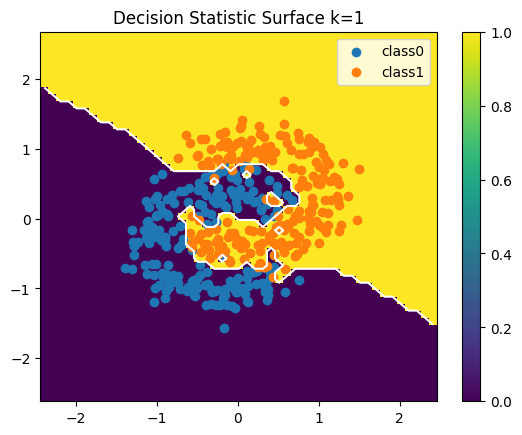

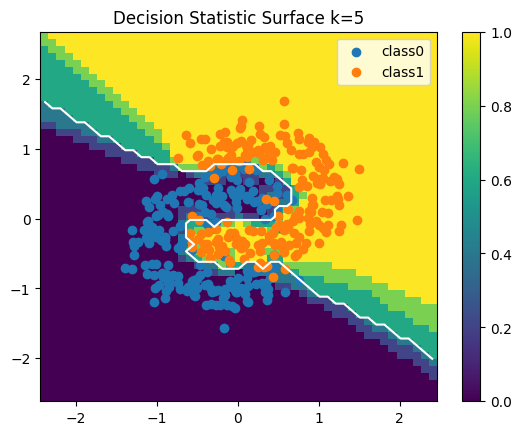

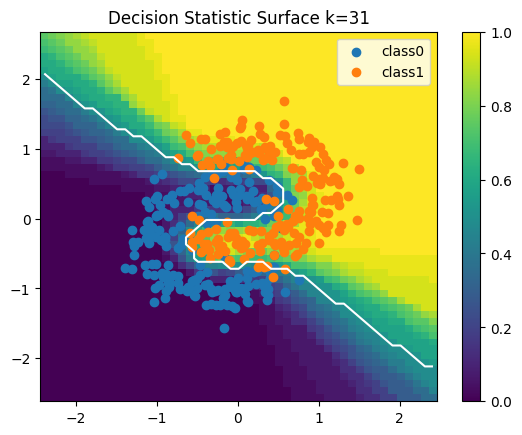

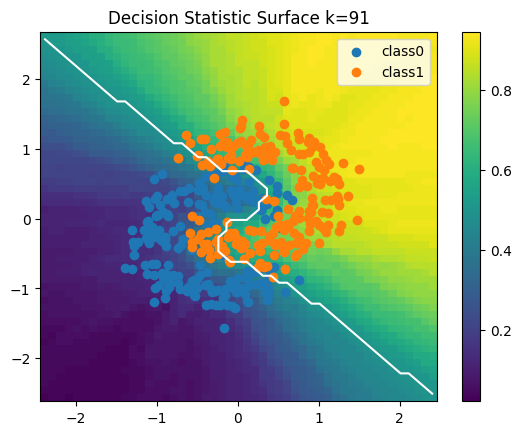

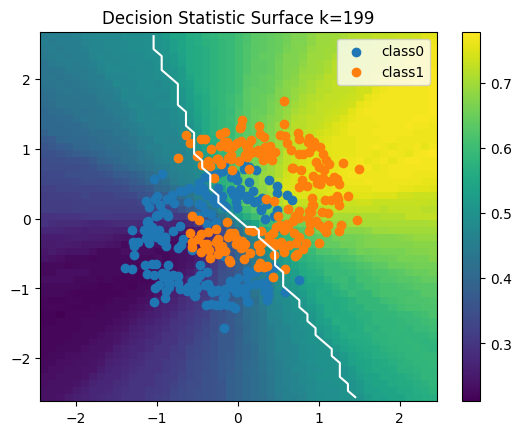

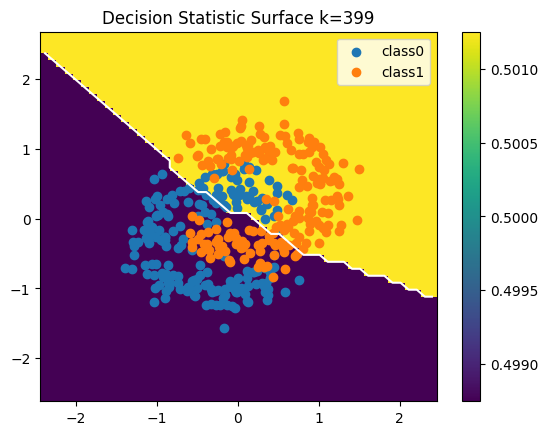

In [38]:
N = horseshoes.shape[0]
Ks = [1,5,31, 91, N//2 -1, N-1]
x = np.arange(np.min(horseshoes[:,1])-1, np.max(horseshoes[:,1])+1, 0.1)
y = np.arange(np.min(horseshoes[:,2])-1, np.max(horseshoes[:,2])+1, 0.1)
# print(np.min(horseshoes[:,1]), np.max(horseshoes[:,1]))
xx,yy = np.meshgrid(x,y)

def getDecisionStatSurface(k,data_x,data_y):
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(data_x,data_y)
    xygrid = np.c_[xx.ravel(), yy.ravel()]
    decision_stats = model.predict_proba(xygrid)
    majority = model.predict(xygrid).reshape(xx.shape)
    return decision_stats, majority
    
class0 = horseshoes[horseshoes[:,0]==0, :]
class1 = horseshoes[horseshoes[:,0]==1, :]
for k in Ks:
    decision_stats, majority = getDecisionStatSurface(k,horseshoes[:,1:3],horseshoes[:,0])
    fig, ax = plt.subplots()
    for i in range(decision_stats.shape[1]):
        im = ax.pcolormesh(xx, yy, decision_stats[:,i].reshape(xx.shape))
    fig.colorbar(im)
    ax.contour(xx, yy, majority, levels=[0.5], colors="w")

    ax.scatter(class0[:,1],class0[:,2], label="class0")
    ax.scatter(class1[:,1],class1[:,2], label="class1")
    ax.legend()
    ax.set_title(f"Decision Statistic Surface k={k}")
    plt.show()
    # break


### 4b

The decision boundary (shown in white) deviates from the ideal decision boundary as $k$ approaches 1 because outliers such as any blue points that are in the middle of a bunch of orange points, will cause the decision boundary to have little holes in the areas that the orange points reside and viseversa for blue points in the orange areas. This is a manifestation of variance as any random changes in the data will cause the decision boundary to change a lot. 

The decision boundary deviates from the ideal decision boundary as $k$ approaches N because each point will now have to consider nearly every training set point. Since the training sets were balanced, this makes the decision boundary a nearly linear line. This is a manifestation of bias as there is a systematic source of error where all points that are nearer to the orange dots of the training set are classified as class 1 and vise versa for the blue dots and class 0.

### 5a

AUC 1: 1.0
AUC 5: 0.9923
AUC 31: 0.9860499999999999
AUC 91: 0.9548125
AUC 199: 0.8175375
AUC 399: 0.7274999999999999


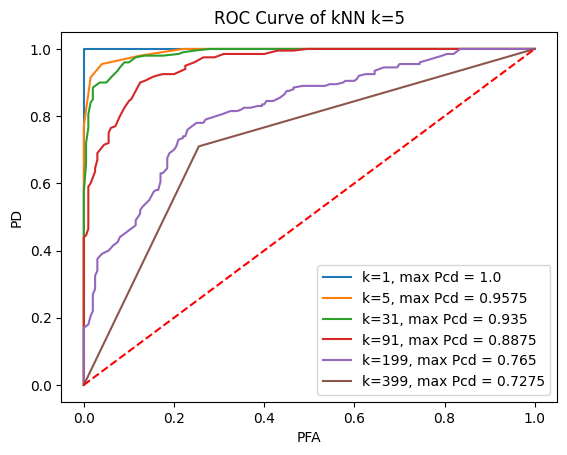

In [13]:
N = horseshoes.shape[0]
Ks = [1,5,31, 91, N//2 -1, N-1]
# class0 = horseshoes[horseshoes[:,0]==0, :]
# class1 = horseshoes[horseshoes[:,0]==1, :]
fig, ax = plt.subplots()
for k in Ks:
    pfa, pd, pcd = myKNN(horseshoes[:,1:3],horseshoes[:,0],horseshoes[:,1:3],horseshoes[:,0],k=k)
    ax.plot(pfa, pd, label=f"k={k}, max Pcd = {pcd}")
    print(f"AUC {k}:", metrics.auc(pfa,pd))
ax.plot([0, 1], [0, 1],'r--')
ax.set_ylabel('PD')
ax.set_xlabel('PFA')
ax.set_title('ROC Curve of kNN k=5')
ax.legend()
plt.show()



### 5b 

Based only on the ROCs, the best way to maximize $P_{cd}$ is to pick $k=1$ because its AUC is 1.0 which is the largest.

### 6a

AUC 1: 0.905
AUC 5: 0.972175
AUC 31: 0.98355
AUC 91: 0.9552875
AUC 199: 0.8234374999999999
AUC 399: 0.74


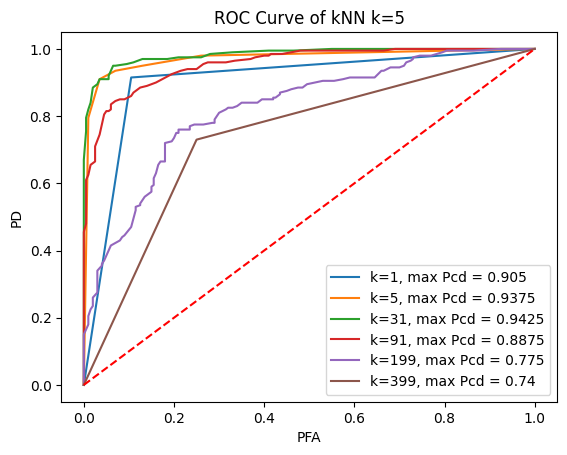

In [14]:
N = horseshoes.shape[0]
Ks = [1,5,31, 91, N//2 -1, N-1]


fig, ax = plt.subplots()
for k in Ks:
    pfa, pd, pcd = myKNN(horseshoesTEST[:,1:3],horseshoesTEST[:,0],horseshoes[:,1:3],horseshoes[:,0],k=k)
    ax.plot(pfa, pd, label=f"k={k}, max Pcd = {pcd}")
    print(f"AUC {k}:", metrics.auc(pfa,pd))

ax.plot([0, 1], [0, 1],'r--')
ax.set_ylabel('PD')
ax.set_xlabel('PFA')
ax.set_title('ROC Curve of kNN k=5')
ax.legend()
plt.show()

### 6b
Based only on the ROCs, the best way to maximize $P_{cd}$ is to pick $k=31$ because the AUC was highest at 0.98 

### 7a

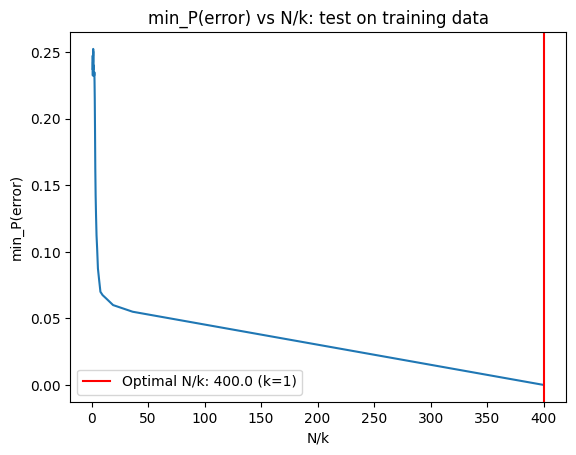

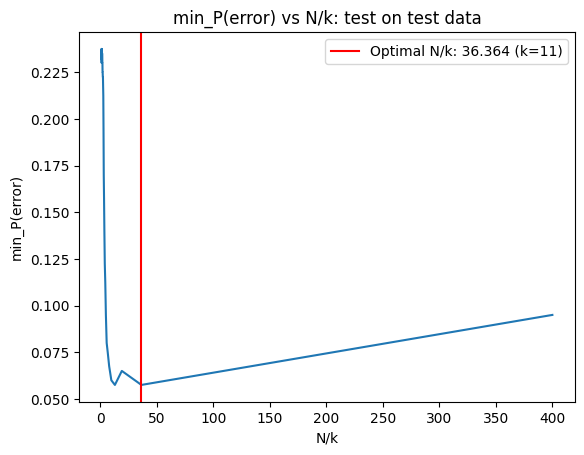

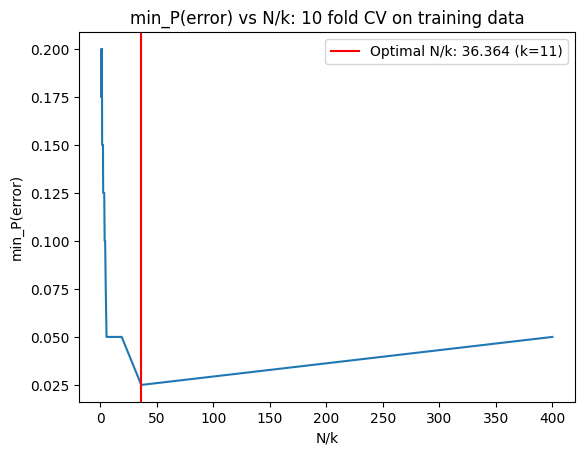

In [43]:
N = horseshoes.shape[0]

# # test on training
fig, ax = plt.subplots()
x = []
y = []
for k in np.arange(1,399, 10): #sample every 10 k
    _, _, pcd = myKNN(horseshoes[:,1:3],horseshoes[:,0],horseshoes[:,1:3],horseshoes[:,0],k=k)
    x.append(N/k)
    y.append(1-pcd)
ax.plot(x, y)
lowest = x[np.argmin(y)]
ax.axvline(lowest, label=f"Optimal N/k: {round(lowest,3)} (k={round(N/lowest)})", c='r')
ax.set_ylabel('min_P(error)')
ax.set_xlabel('N/k')
ax.set_title('min_P(error) vs N/k: test on training data')
ax.legend()
plt.show()

# # # test on testing
fig, ax = plt.subplots()
x = []
y = []
for k in np.arange(1,399, 10): #sample every 10 k
    pfa, pd, pcd = myKNN(horseshoesTEST[:,1:3],horseshoesTEST[:,0],horseshoes[:,1:3],horseshoes[:,0],k=k)
    x.append(N/k)
    y.append(1-pcd)
ax.plot(x, y)
lowest = x[np.argmin(y)]
ax.axvline(lowest, label=f"Optimal N/k: {round(lowest,3)} (k={round(N/lowest)})", c='r')
ax.set_ylabel('min_P(error)')
ax.set_xlabel('N/k')
ax.set_title('min_P(error) vs N/k: test on test data')
ax.legend()
plt.show()
    
# 10 fold CV on training
def TenFoldCVKNN(datax, datay, k=5):
    
    model = KNeighborsClassifier(n_neighbors=k)
    kf = KFold(n_splits=10)

    pcds = []
    for train_index, test_index in kf.split(datax):
        x_train, x_test, y_train, y_test = datax[train_index], datax[test_index], datay[train_index], datay[test_index]
        model.fit(x_train,y_train)

        decision_stats = model.predict_proba(x_test)[:, 1]
        pFA, pD, threshold = roc_curve(y_test, decision_stats)
        maxPCD = 0
        for i in threshold:
            y_hat = np.where(decision_stats >= i, 1, 0)
            pCD = sum(y_hat==y_test) / y_test.shape[0]
            maxPCD = max(pCD,maxPCD)
        pcds.append(maxPCD)
    return np.mean(maxPCD)

fig, ax = plt.subplots()
x = []
y = []
for k in np.arange(1,359, 10): #sample every 10 k. capped at 360 because 10fold CV makes training set size 400*0.9
    pcd = TenFoldCVKNN(horseshoes[:,1:3],horseshoes[:,0],k=k)
    x.append(N/k)
    y.append(1-pcd)
ax.plot(x, y)
ax.set_ylabel('min_P(error)')
lowest = x[np.argmin(y)]
ax.axvline(lowest, label=f"Optimal N/k: {round(lowest,3)} (k={round(N/lowest)})", c='r')
ax.set_xlabel('N/k')
ax.set_title('min_P(error) vs N/k: 10 fold CV on training data')
ax.legend()
plt.show()

The cross validated performance has very similar results to the KNN that tested on testing data. If we read the graph from right to left, as $K$ increases from 1, the minimum probability of error decreases steadily until $k$ exceeds 11. Then it rises very quickly as $k$ approaches $N$. The optimal value of $k$ is shown to be 11. 

This illustrates the principle of bias-variance trade-off because at low values of $k$ (higher N/k), there is low bias meaning there is less systematic error in the predictions, leading to lower error. At high values of k (lower N/k), there is high bias, meaning there is more systematic error in the predictiosn, leading to higher error. 

The effect on variance can be seen by comparing the graph of KNN tested on training data vs KNN tested on testing data. When testing on training data, the optimal $k$ was 1. However, this isn't optimal when testing on new testing data which showcases how higher k (which has lower bias) has higher variance, as it is not longer optimal for new data. The cross-validated KNN graph shows that if we set $k$ to be 11, there is less variance since the optimal $k$ remains the same with new data inputs.

### 7b

Based on the graphs, the optimal value of $k$ is 11. If there was no separate test data available, I would do 10-fold cross validation on the training data to select my optimal $k$.